# Intro
 
The datasets includes:

- Participants: participant number

- Four columns for the second-order strengths factors previously extracted via PCA:
    - Openness
    - Restraint
    - Transcendence
    - Interpersonal
    
- The three dependent measures: 
    - DASS21 (Depression Anxiety and Stress Scale) 
    - GHQ12 (General Health Questionnaire) : the higher the score, the worst the mental health
    - SEC (Self-efficacy for Covid-19)
- Six demographic variables added in the analysis:
    - Age
    - Gender
    - Work (representing the perceived work change subsequent to lockdown)
    - Student (being a student or not)
    - Day (how many days passed when the participant responded since the day the survey was opened)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('default') # to plot white graphs despite black background
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
#sns.set_style('whitegrid')

# Writing the class PCA_from_scratch

In [2]:
class PCA_from_scratch:
    
    def __init__(self, k_components):
        # number of principal components to be returned
        self.k_components = k_components
        # principal directions are eigenvectors of the covariance matrix
        self.principal_directions = None
        # mean to be subtracted from X in order to center the problem and express Cov(X) = (1/n)*Xt @ X
        self.mean = None
        # Variance associated to every principal component
        self.variance_along_principal_direction = None
        # Proportion of explained variance associated with every principal component
        self.explained_variance_ratio = None
        # Cumulative roportion of explained variance
        self.cum_explained_variance_ratio = None
    
    def fit(self, X):
        # Factors are in cols, so I do the mean column wise
        self.mean = np.mean(X, axis = 0)
        X = X - self.mean
        
        # rowvar = False because in X I want observations on rows and factors on cols
        covariance_matrix = np.cov(X, rowvar = False)
        
        # eigenvalues and eigenvectors aren't necessary ordered
        # eigenvectors are column vectors
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        # Now I sort eigenvalues and eigenvectors from the biggest --> argsort returns the indices that sort an array
        idx_eigenvalues_ordered = np.argsort(eigenvalues)[::-1] # with -1 I read from the end of the array
        eigenvalues_ordered = eigenvalues[idx_eigenvalues_ordered]
        eigenvectors_ordered = eigenvectors.T[idx_eigenvalues_ordered] # eigenvectors_ordered are on rows now
        
        self.explained_variance_ratio = eigenvalues_ordered / np.sum(eigenvalues_ordered)
        
        self.cum_explained_variance_ratio = np.cumsum(eigenvalues_ordered) / np.sum(eigenvalues_ordered)
        
        # If I want the first k-PCs, I have to consider only the first k-principal_directions (aka eigenvectors of covariance)
        self.principal_directions = eigenvectors_ordered[0:self.k_components,:]
        
        # If I want the vaiance of data along the first k principal directions, I have to consider only the first k-eigenvalues
        self.variance_along_principal_direction = eigenvalues_ordered[0:self.k_components]
        
        # If I want the explained variance ratio for first k-PCs, I have to consider only the first k-principal_directions
        self.explained_variance_ratio = self.explained_variance_ratio[0:self.k_components]
        self.cum_explained_variance_ratio = self.cum_explained_variance_ratio[0:self.k_components]

        
    def transform(self, X):
        X = X - self.mean
        principal_components = X @ self.principal_directions.T
        return(principal_components)

# Importing the dataframe

As I wrote in the introduction, the original table contained 4 sintetic factors already extracted from the original ones. So I delete them because they shouldn't influence the analysis. At the end of the PCA, I expect to find similar conclusions concerning the extrapolation and interpretation of the new factors.

In [3]:
df = pd.read_excel(r'C:\Users\peria\Desktop\GitHub\PCA\PCA_Covid_Psyco_Survey.xlsx', index_col = 0)

# Preprocessing of features
df.drop(columns = ['Day', 'DASS_21', 'Openness', 'Restraint', 'Transcendence', 'Interpersonal'], inplace = True)
df.dropna(inplace = True)
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Student'] = df['Student'].map({'Other': 0, 'Student': 1})

df.head()

,GHQ_12,SEC,Age,Gender,Work,Student,Sons,Appreciation_of_beauty,Bravery,Creativity,...,Perspective,Prudence,Self_regulation,Social_intelligence,Spirituality,Teamwork,Zest,DASS_anxiety,DASS_depression,DASS_stress
Participant,,,,,,,,,,,,,,,,,,,,,
1,24,11,26,0,5,1,0,19,17,17,...,13,18,13,16,15,22,20,0,7,8
2,15,20,25,1,1,0,0,18,16,16,...,18,15,20,15,17,15,18,4,5,9
3,7,20,26,1,1,0,0,15,16,16,...,19,17,22,17,11,12,15,0,0,0
4,18,18,25,0,6,0,0,22,15,22,...,19,24,15,21,12,11,19,1,4,10
5,19,14,49,0,5,0,1,21,18,25,...,20,18,24,15,21,18,21,14,8,15


In [4]:
# Understanding variable tipology
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 944
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   GHQ_12                  943 non-null    int64
 1   SEC                     943 non-null    int64
 2   Age                     943 non-null    int64
 3   Gender                  943 non-null    int64
 4   Work                    943 non-null    int64
 5   Student                 943 non-null    int64
 6   Sons                    943 non-null    int64
 7   Appreciation_of_beauty  943 non-null    int64
 8   Bravery                 943 non-null    int64
 9   Creativity              943 non-null    int64
 10  Curiosity               943 non-null    int64
 11  Fairness                943 non-null    int64
 12  Forgiveness             943 non-null    int64
 13  Gratitude               943 non-null    int64
 14  Honesty                 943 non-null    int64
 15  Hope                   

# Plotting correlation of variables

If the correlation between variables is high, probably the covariance between factors is also high, so it's likely to find some sintetic Principal Components Factors that can substitute the original ones in our analysis.

$\rho[X_{1}, X_{2}] = \frac{cov[X_{1}, X_{2}]}{\sigma_{1} \sigma_{2}}$

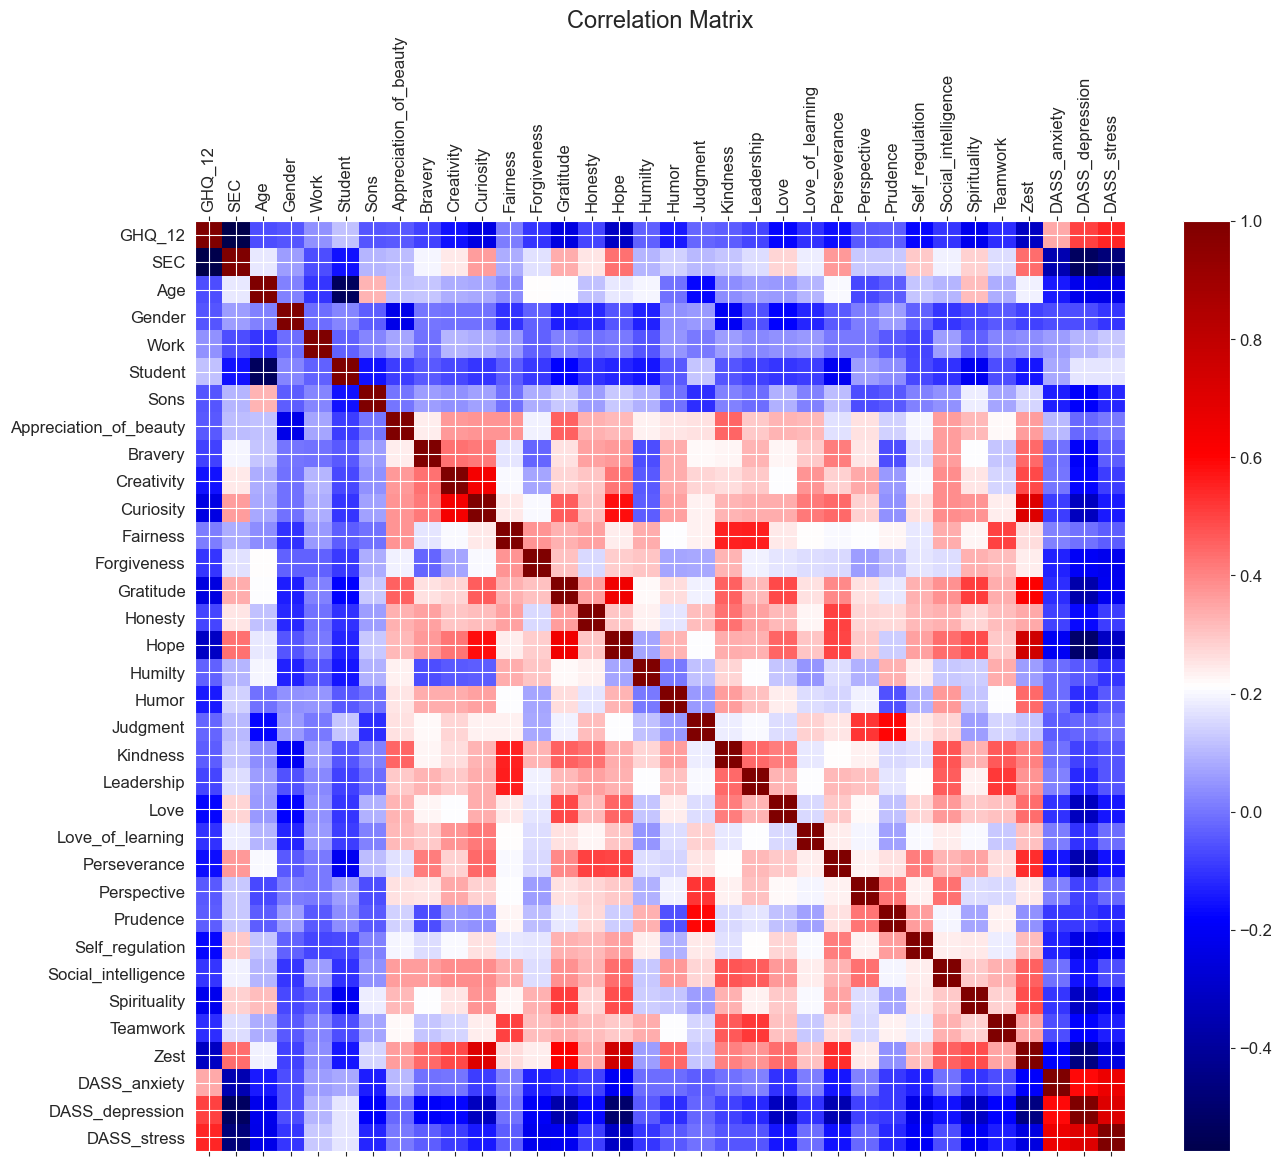

In [5]:
fig = plt.figure(figsize=(15, 12))
plt.matshow(df.corr(), fignum = fig.number, cmap='seismic')
plt.xticks(range(df.shape[1]), df.columns, fontsize = 12, rotation = 90)
plt.yticks(range(df.shape[1]), df.columns, fontsize = 12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize = 17)
plt.show()

# Scaling the features

Basically the standard score of a variable X (with paramenters $\mu$ and $\sigma$) is calculated as $Z = \frac{X - \mu}{\sigma}$

In [6]:
import sklearn
from sklearn.preprocessing import StandardScaler

cols = df.columns

scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
df = pd.DataFrame(scaled_data, columns = cols)

print('Now the dataframe is standardized --> mean 0 and std_dev 1')
df.head()

Now the dataframe is standardized --> mean 0 and std_dev 1


,GHQ_12,SEC,Age,Gender,Work,Student,Sons,Appreciation_of_beauty,Bravery,Creativity,...,Perspective,Prudence,Self_regulation,Social_intelligence,Spirituality,Teamwork,Zest,DASS_anxiety,DASS_depression,DASS_stress
0,1.425099,-1.016552,-0.775885,-0.585922,0.842172,1.921339,-0.735425,-0.356575,-0.407557,-0.368502,...,-1.485229,0.090955,-1.069667,-0.974808,-0.071229,1.367322,0.773433,-0.871627,0.416411,0.217858
1,-0.411623,1.241359,-0.844870,1.706711,-1.751030,-0.520470,-0.735425,-0.703583,-0.721036,-0.661997,...,0.079655,-0.821500,0.921554,-1.345620,0.417270,-1.230000,0.208485,0.326979,-0.030573,0.447915
2,-2.044266,1.241359,-0.775885,1.706711,-1.751030,-0.520470,-0.735425,-1.744607,-0.721036,-0.661997,...,0.392632,-0.213197,1.490474,-0.603995,-1.048227,-2.343138,-0.638936,-0.871627,-1.148034,-1.622593
3,0.200618,0.739601,-0.844870,-0.585922,1.490473,-0.520470,-0.735425,0.684448,-1.034516,1.098971,...,0.392632,1.915867,-0.500746,0.879254,-0.803977,-2.714183,0.490959,-0.571975,-0.254065,0.677971
4,0.404698,-0.263915,0.810780,-0.585922,0.842172,-0.520470,1.359758,0.337440,-0.094077,1.979455,...,0.705608,0.090955,2.059395,-1.345620,1.394269,-0.116862,1.055907,3.323495,0.639903,1.828253


# Calculate the PCs using the class PCA from scratch

Here I calculate the principal components $Y = PCs = XV$. Each new principal component $Y^{j}$ is a linear combination of the original factors $x^{1}, ... , x^{d}$, using the components of a specific principal direction $ v^{j} $ as weights of the linear combination: $Y^{j} = x^{1}v^{j}_{1} + x^{2}v^{j}_{2} + ... + x^{d}v^{j}_{d}$.

In this case I only take the first k - principal components, so that we have dimensionally reduced the problem:

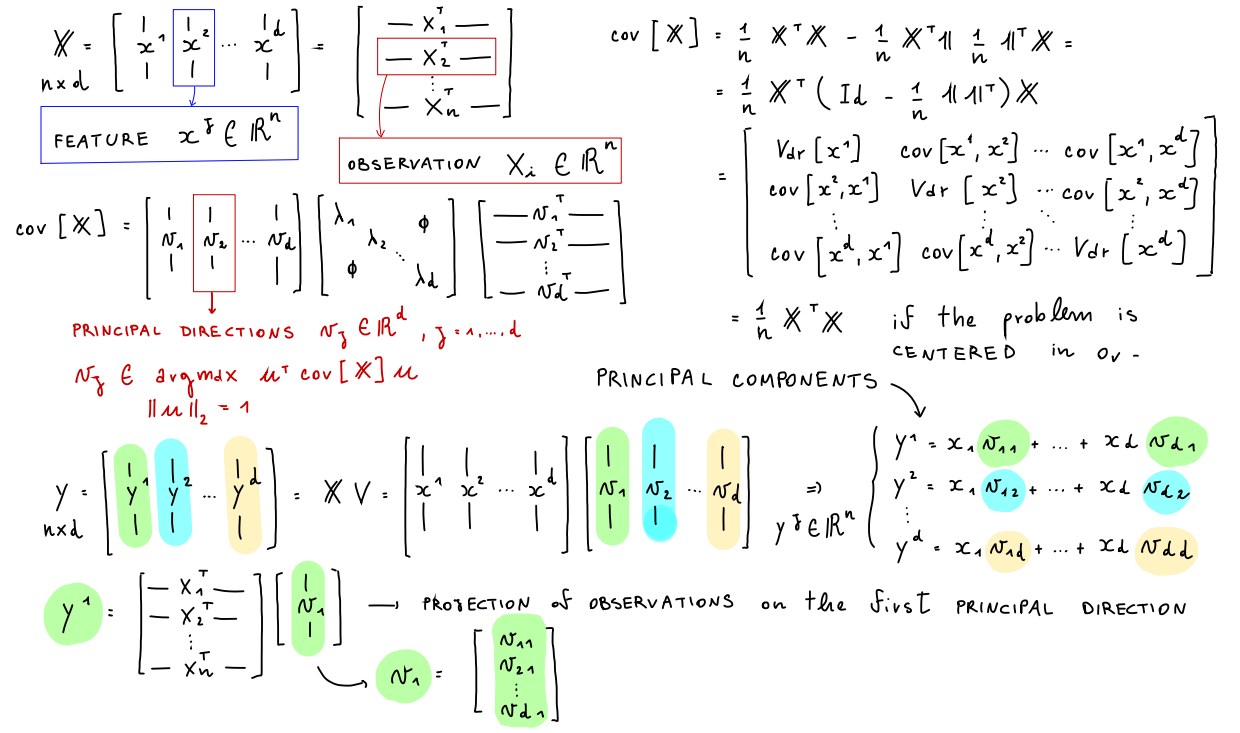

In [7]:
from PCA_from_scratch import PCA_from_scratch
k = 10
# Create object
PCA_from_scratch = PCA_from_scratch(k_components = k)
# Fit method
PCA_from_scratch.fit(df.values)
# Transform method
PCs = PCA_from_scratch.transform(df.values)
df_PCA_from_scratch = pd.DataFrame(np.real(PCs), columns = ['PC' + str(j) for j in range(1, k+1)])

print('Principal Components PCs:')
df_PCA_from_scratch

Principal Components PCs:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.163304,1.279722,0.925323,0.631546,2.291571,0.951877,0.559771,-0.272140,0.385804,1.505234
1,-2.435297,-1.840357,-0.499676,-0.282676,0.158767,0.281714,0.593521,2.287206,0.606362,0.137090
2,-2.287108,-4.214146,-0.897345,-3.222271,0.252322,0.293509,0.245902,1.337143,0.174208,-1.830204
3,0.829387,0.156663,-2.791356,-2.747720,-2.212163,2.770535,1.008097,-2.038684,-0.084765,0.006440
4,1.563233,1.101838,-2.412385,0.507003,-4.837004,2.244497,1.045260,0.319083,1.849115,1.448717
...,...,...,...,...,...,...,...,...,...,...
938,2.784894,2.961161,-0.974452,1.406457,-0.615975,-0.564282,-0.321548,1.565419,2.210830,-0.993839
939,1.001226,-0.423181,0.822430,3.513727,1.077906,-1.149154,-0.876739,0.472385,-1.220856,-0.671781
940,6.258854,0.213705,-2.978588,-0.466555,0.483390,-0.378884,1.358176,0.316549,-0.060431,0.465385
941,-3.414328,-2.157957,1.740978,1.710949,-0.074789,2.022236,-2.234071,-1.349389,1.763856,-0.089213


# Extract the first k-principal directions

In [8]:
print('The principal directions directly from the class PCA_from_scratch')
# Remember that the principal direction (aka eigenvectors are the rows of this matrix) are stored row by row
PCA_from_scratch.principal_directions

The principal directions directly from the class PCA_from_scratch


array([[-1.23878442e-01,  1.82025099e-01,  8.85647685e-02,
        -3.66608611e-02,  6.95090821e-03, -7.43381701e-02,
         5.08923431e-02,  1.84774869e-01,  1.72478102e-01,
         1.94898651e-01,  2.41590483e-01,  1.76106223e-01,
         1.35704294e-01,  2.50889118e-01,  2.01814494e-01,
         2.65054185e-01,  9.67960132e-02,  1.49883174e-01,
         1.28762572e-01,  2.07513926e-01,  2.00130835e-01,
         1.99905944e-01,  1.50537494e-01,  2.16975529e-01,
         1.54256389e-01,  1.04579804e-01,  1.67478926e-01,
         2.16287308e-01,  2.01000335e-01,  1.81185429e-01,
         2.74608764e-01, -7.88300081e-02, -1.74090947e-01,
        -1.20897749e-01],
       [ 3.07036517e-01, -2.66599762e-01, -1.92001804e-01,
        -1.02091372e-01,  9.74607844e-02,  1.49318243e-01,
        -1.45502259e-01,  1.88183125e-01,  6.31289082e-02,
         7.87230046e-02,  8.04218765e-03,  2.14259714e-01,
        -2.85596576e-02, -1.77022012e-02,  1.02352490e-01,
        -9.29048643e-02,  6.29

I put the principal directions into a dataframe and I reindex putting the name of the corrispondenting factor. 
Taking each principal direction, each coordinate is associated to an original features. The number express the magnitude of the link between each original factor and the principal direction. 

In fact if we have centered the problem, the covariance matrix of the table X is:

$cov[X] = \frac{1}{n}X^{T}X$

but if we apply the singular value decomposition of X:

$cov[X] = \frac{1}{n}V\Sigma^{T}\Sigma V^{T}$

So the row space of X is spanned by $v^{1}, ...,v^{d}$, which are also the eigenvectors of the covariance matric of $cov[X]$ itself.

So there is a link between $v^{1}, ...,v^{d}$ and $x^{1}, ...,x^{d}$.

Furthermore $v^{1}, ...,v^{d}$ are the directions in which the variance of the prijected observations is the highest.

Someone calls improperly **loadings** this vectors. To be honest the loadings are $v^{1} \sqrt{\lambda_{1}}, ...,v^{d} \sqrt{\lambda_{d}}$.

In [9]:
df_principal_directions = pd.DataFrame(PCA_from_scratch.principal_directions.T,
                                       columns = ['EigenV' + str(j+1) for j in
                                                  range(PCA_from_scratch.principal_directions.shape[0])],
                                       index = cols)
df_principal_directions

,EigenV1,EigenV2,EigenV3,EigenV4,EigenV5,EigenV6,EigenV7,EigenV8,EigenV9,EigenV10
GHQ_12,-0.123878,0.307037,0.039554,0.127481,-0.197614,-0.076498,-0.118710,0.017506,0.222472,0.037925
SEC,0.182025,-0.266600,-0.024414,-0.126272,0.032984,0.036410,0.024273,0.002747,-0.143190,0.106963
Age,0.088565,-0.192002,0.124402,0.319070,-0.402085,-0.210168,0.094007,0.051002,-0.060004,-0.185322
Gender,-0.036661,-0.102091,-0.064324,-0.198951,-0.008268,-0.567226,0.257681,0.101031,0.374221,0.015506
Work,0.006951,0.097461,-0.111419,0.075651,0.066425,0.030826,0.246145,-0.813565,0.123703,0.215764
Student,-0.074338,0.149318,-0.083778,-0.286757,0.341239,0.193216,-0.079161,0.153420,0.243318,0.219787
Sons,0.050892,-0.145502,0.049647,0.224961,-0.207234,-0.061964,-0.083563,-0.307714,0.272598,-0.062574
Appreciation_of_beauty,0.184775,0.188183,-0.000219,0.115209,-0.030498,0.264675,0.205219,0.020160,-0.184235,-0.228038
Bravery,0.172478,0.063129,-0.296155,-0.002764,-0.123721,-0.225160,-0.228456,0.084097,-0.162915,0.096797
Creativity,0.194899,0.078723,-0.304604,-0.042257,-0.085617,-0.073548,0.237293,-0.019127,-0.125771,-0.026797


PROOF that the eigenvalues are the variance of data projected on the first principal directions

In [14]:
list_variance_along_prin_dir = []

# Factors are on te columns while on the rows I see observations
covariance_matrix = np.cov(df.values, rowvar = False)

for j in range(k):
    variance_along_prin_dir = PCA_from_scratch.principal_directions[j].T @ covariance_matrix \
                              @ PCA_from_scratch.principal_directions[j]
                            
    
    list_variance_along_prin_dir.append(np.real(variance_along_prin_dir))

print('\nCovariance of data projected on the first k principal directions:\n', list_variance_along_prin_dir)
print('\nEigenvalues by PCA_from_scratch class\n:', np.real(PCA_from_scratch.variance_along_principal_direction))


Covariance of data projected on the first k principal directions:
 [8.455113575828154, 3.2760657303915366, 2.208857450822572, 2.08652817786509, 1.5254041516544505, 1.2143872148244212, 1.0976150238620899, 1.0184769579268491, 0.9975275044017088, 0.9490747999399076]

Eigenvalues by PCA_from_scratch class
: [8.45511358 3.27606573 2.20885745 2.08652818 1.52540415 1.21438721
 1.09761502 1.01847696 0.9975275  0.9490748 ]


# Scree Plot

The Scree Plot allows us to understand how much PCs should be considered at the end of the game. The choice is made on the explained variance propotion associated with each different principal direction:
 - $v_{1}^{T}Cov[X]v_{1} = \lambda_{1} $
 - $v_{2}^{T}Cov[X]v_{2} = \lambda_{2} $
 - ... 
 - $v_{d}^{T}Cov[X]v_{d} = \lambda_{d} $
 
 The proportion of explained variance brung by a specific principal component is: 
 
 $\frac{\lambda_{j}}{\lambda_{1} + ... + \lambda_{d}}$ 
 
 and the explained variance of the first k components is:
 
 $\frac{\lambda_{1} + ... + \lambda_{k}}{\lambda_{1} + ... + \lambda_{d}}$

Scree Plot to understand how much PCs will go in the final graph

Proportion of explaine variance of each component:
 [0.2484161  0.0962527  0.0648975  0.0613034  0.04481725 0.03567939
 0.03224856 0.02992344 0.02930793 0.02788436] 


Proportion of explaine variance of the first k-component:
 [0.2484161  0.3446688  0.4095663  0.4708697  0.51568695 0.55136634
 0.5836149  0.61353834 0.64284627 0.67073064]


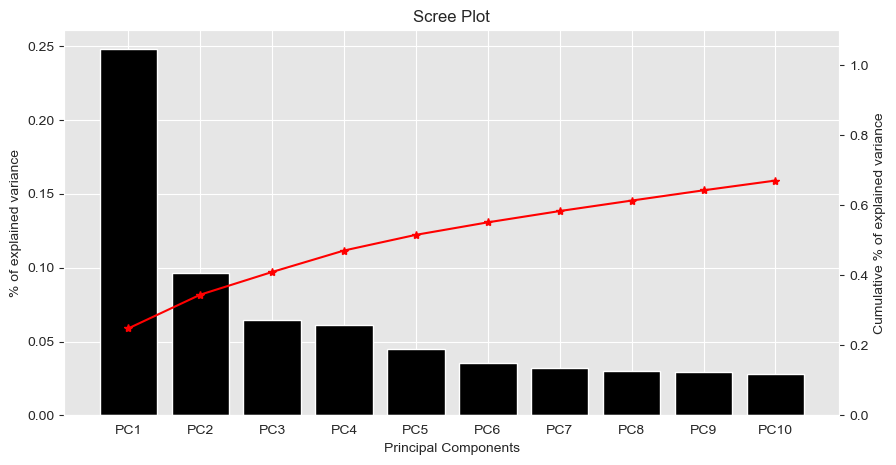

In [10]:
print('Scree Plot to understand how much PCs will go in the final graph\n')

fig, ax = plt.subplots(figsize = (10, 5))

axt = ax.twinx()

# percentage of explained variance (lambda_k) / (lambda_1 + ... + lambda_d)
perc_var = PCA_from_scratch.explained_variance_ratio
print('Proportion of explaine variance of each component:\n', perc_var, '\n\n')

# cumulative percentage of explained variance (lambda_1 + lambda_k) / (lambda_1 + ... + lambda_d)
cum_var = PCA_from_scratch.cum_explained_variance_ratio
print('Proportion of explaine variance of the first k-component:\n', cum_var)

labels = ['PC' + str(j) for j in range(1, len(perc_var) + 1)]
ax.bar(labels, perc_var, color = 'black')

axt.plot(labels, cum_var, color = 'red', marker = '*')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% of explained variance')
axt.set_ylabel('Cumulative % of explained variance')
ax.set_title('Scree Plot')

axt.set_ylim([0, 1.1])
axt.grid(False)
plt.show()

# Link between the first principal_directions and original features 

Understanding the link between original factors and the first principal directions along which I get the highest variance

In [12]:
principal_direction_1 = pd.Series(np.real(PCA_from_scratch.principal_directions[0]), index = cols)
idx_sorted = principal_direction_1.abs().sort_values(ascending = False).index
principal_direction_1 = principal_direction_1[idx_sorted]


principal_direction_2 = pd.Series(np.real(PCA_from_scratch.principal_directions[1]), index = cols)
idx_sorted = principal_direction_2.abs().sort_values(ascending = False).index
principal_direction_2 = principal_direction_2[idx_sorted]


principal_direction_3 = pd.Series(np.real(PCA_from_scratch.principal_directions[2]), index = cols)
idx_sorted = principal_direction_3.abs().sort_values(ascending = False).index
principal_direction_3 = principal_direction_3[idx_sorted]


principal_direction_4 = pd.Series(np.real(PCA_from_scratch.principal_directions[3]), index = cols)
idx_sorted = principal_direction_4.abs().sort_values(ascending = False).index
principal_direction_4 = principal_direction_4[idx_sorted]


# Legame tra fattori originari e PC2:
print('\nLink (sorted basing on importance) between PC1 and original factors:\n', principal_direction_1)
print('\nLink (sorted basing on importance) between PC2 and original factors:\n', principal_direction_2)
print('\nLink (sorted basing on importance) between PC3 and original factors:\n', principal_direction_3)
print('\nLink (sorted basing on importance) between PC4 and original factors:\n', principal_direction_4)


Link (sorted basing on importance) between PC1 and original factors:
 Zest                      0.274609
Hope                      0.265054
Gratitude                 0.250889
Curiosity                 0.241590
Perseverance              0.216976
Social_intelligence       0.216287
Kindness                  0.207514
Honesty                   0.201814
Spirituality              0.201000
Leadership                0.200131
Love                      0.199906
Creativity                0.194899
Appreciation_of_beauty    0.184775
SEC                       0.182025
Teamwork                  0.181185
Fairness                  0.176106
DASS_depression          -0.174091
Bravery                   0.172478
Self_regulation           0.167479
Perspective               0.154256
Love_of_learning          0.150537
Humor                     0.149883
Forgiveness               0.135704
Judgment                  0.128763
GHQ_12                   -0.123878
DASS_stress              -0.120898
Prudence           

# Change of space: original features --> principal components

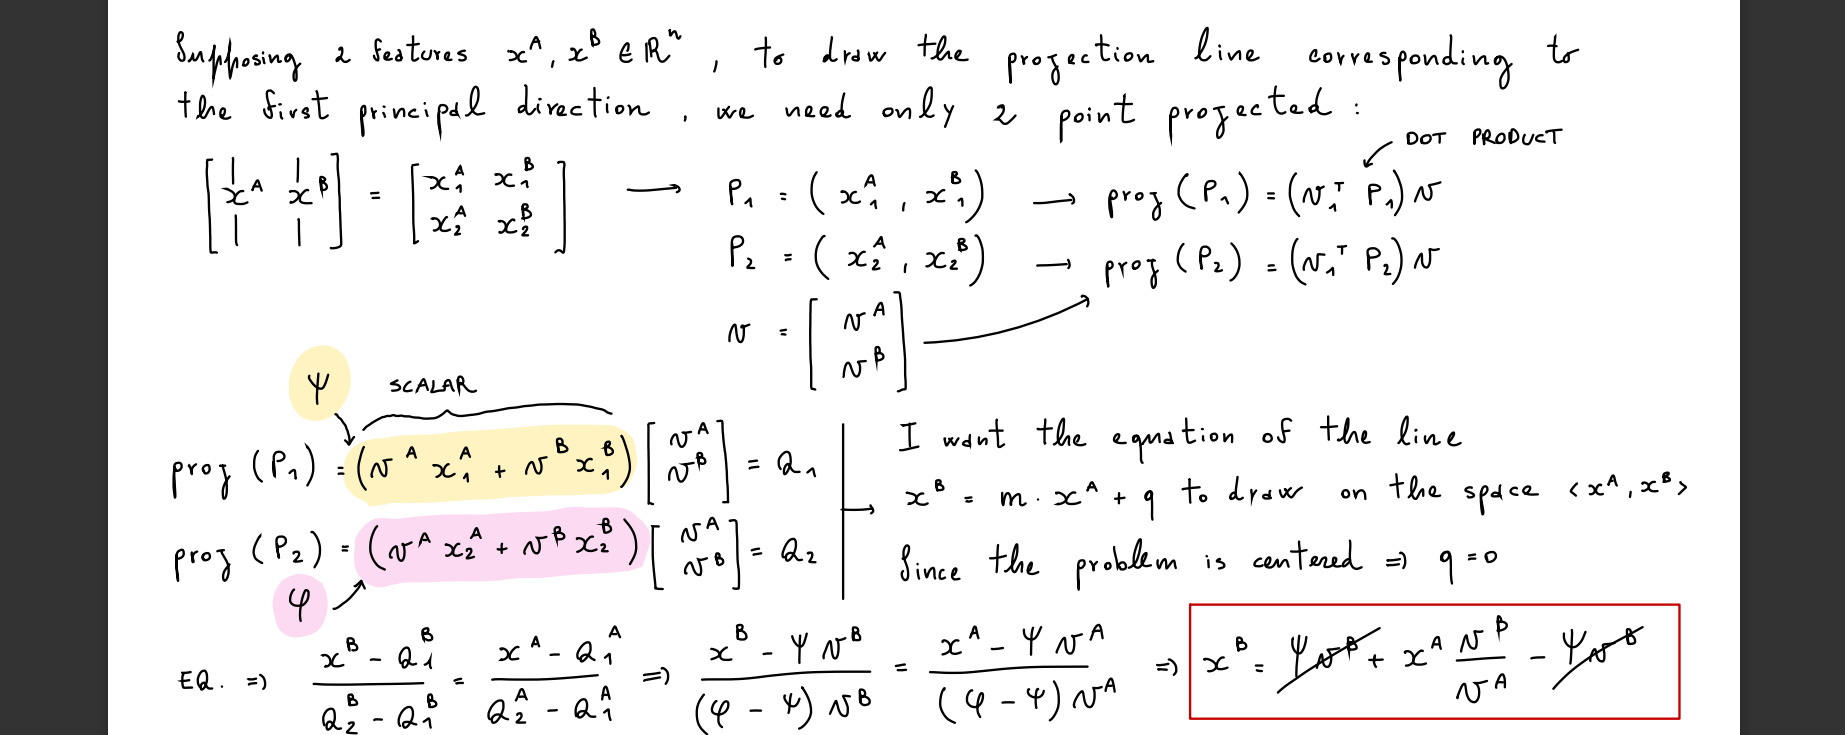

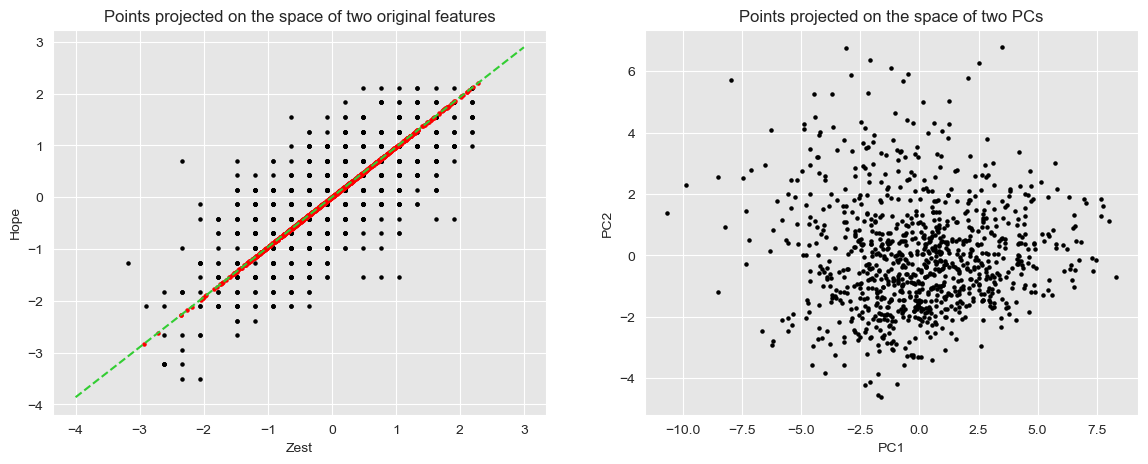

In [21]:
fig, ax = plt.subplots(1, 2, figsize = [14,5])

factor_1 = 'Zest'
factor_2 = 'Hope'

ax[0].scatter(df[factor_1], df[factor_2], s = 5, c = 'black')
ax[0].set_xlabel(factor_1, fontsize = 10)
ax[0].set_ylabel(factor_2, fontsize = 10)

# Considering PC1, PC2, X1, X2, V1, V2 be column vectors --> [PC1 PC2] = [X1 X2][V1 V2]
# PC1_1 = X1_1 * V1_1 + X2_1 * V1_2
# PC1_2 = X1_2 * V1_1 + X2_2 * V1_2
#...
# PC1_n = X1_n * V1_1 + X2_n * V1_2
# Projection of point P = [X1_1, X2_1] along V1 = [V1_1, V1_2] is np.dot(P, V1) = PC1_1
# if I multiply by vector V1 I obtain the vector np.dot(P, V1)*V1 = PC1_1*V1

for j in range(df.shape[0]):
    ax[0].scatter( df_PCA_from_scratch['PC1'][j] * principal_direction_1[factor_1],
                   df_PCA_from_scratch['PC1'][j] * principal_direction_1[factor_2],
                   s = 5, c = 'red')
    
# Ablining the projection line corresponging to the first pricipal direction
min_asc = min(ax[0].get_xticks())
max_asc = max(ax[0].get_xticks())
q = 0
m = principal_direction_1[factor_2] / principal_direction_1[factor_1]
min_ord = m*min_asc + q
max_ord = m*max_asc + q
ax[0].plot([min_asc, max_asc], [min_ord, max_ord], linestyle = '--', c = 'limegreen')

ax[1].scatter(df_PCA_from_scratch['PC1'], df_PCA_from_scratch['PC2'], s = 5, c = 'black')

ax[1].set_xlabel('PC1', fontsize = 10)
ax[1].set_ylabel('PC2', fontsize = 10)

ax[0].set_title('Points projected on the space of two original features')
ax[1].set_title('Points projected on the space of two PCs')

plt.show()

# 3D PLOT of DATA

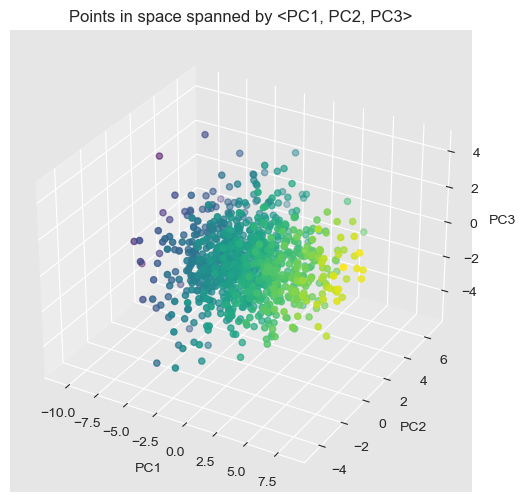

In [35]:
fig = plt.figure(figsize = [18, 6])
ax = fig.add_subplot(projection = '3d')
ax.scatter(df_PCA_from_scratch['PC1'], df_PCA_from_scratch['PC2'], df_PCA_from_scratch['PC3'], 
           c = df_PCA_from_scratch['PC1'], cmap = 'viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Points in space spanned by <PC1, PC2, PC3>')

plt.show()

# BIPLOT

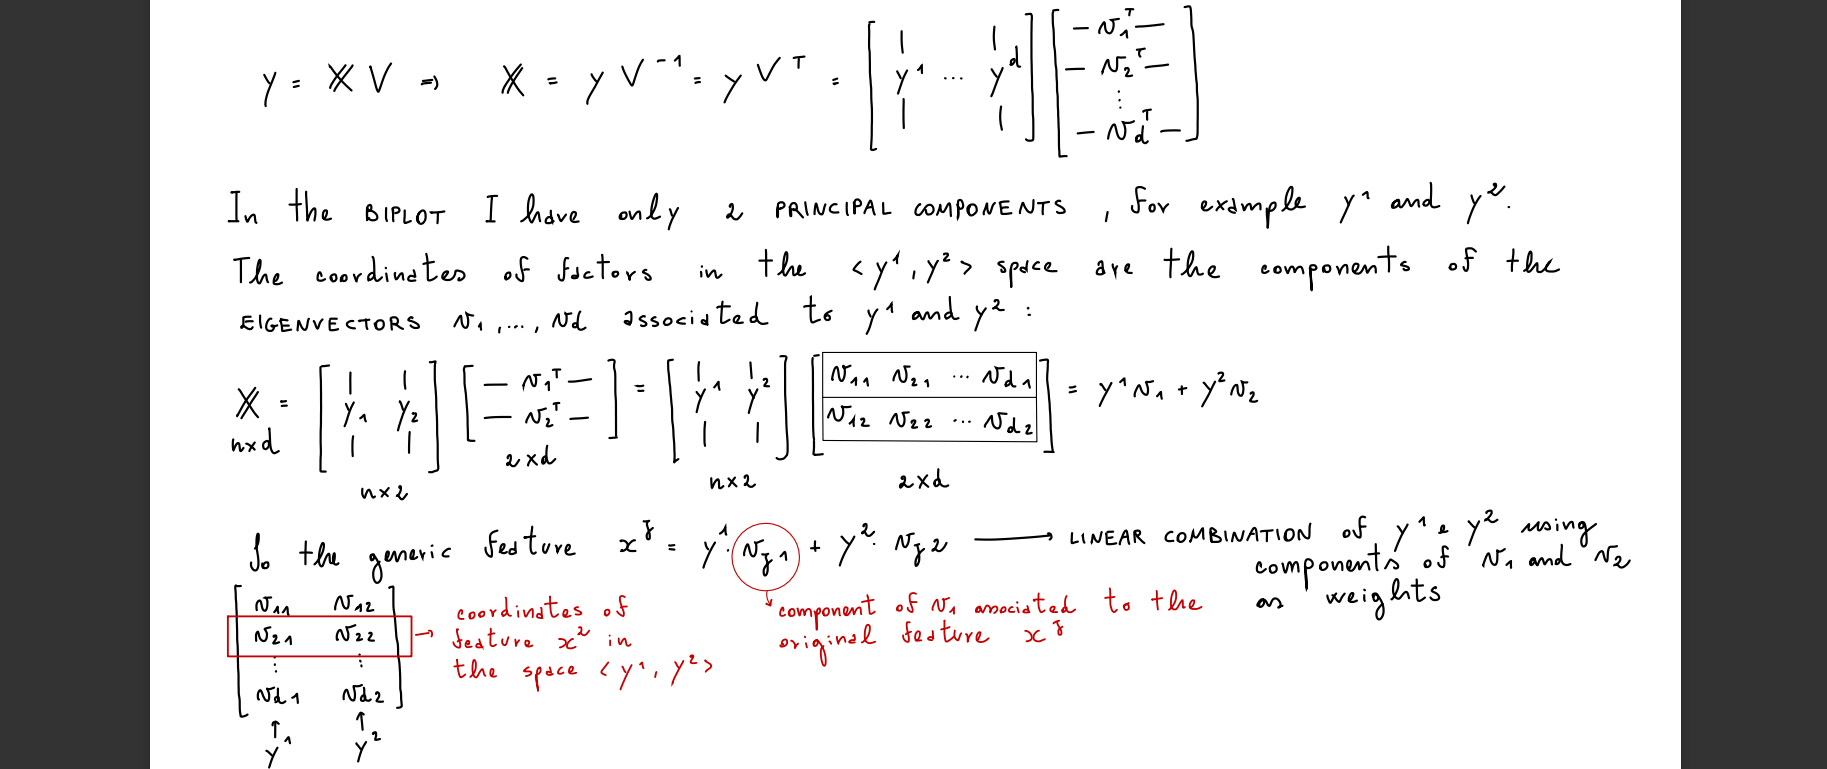

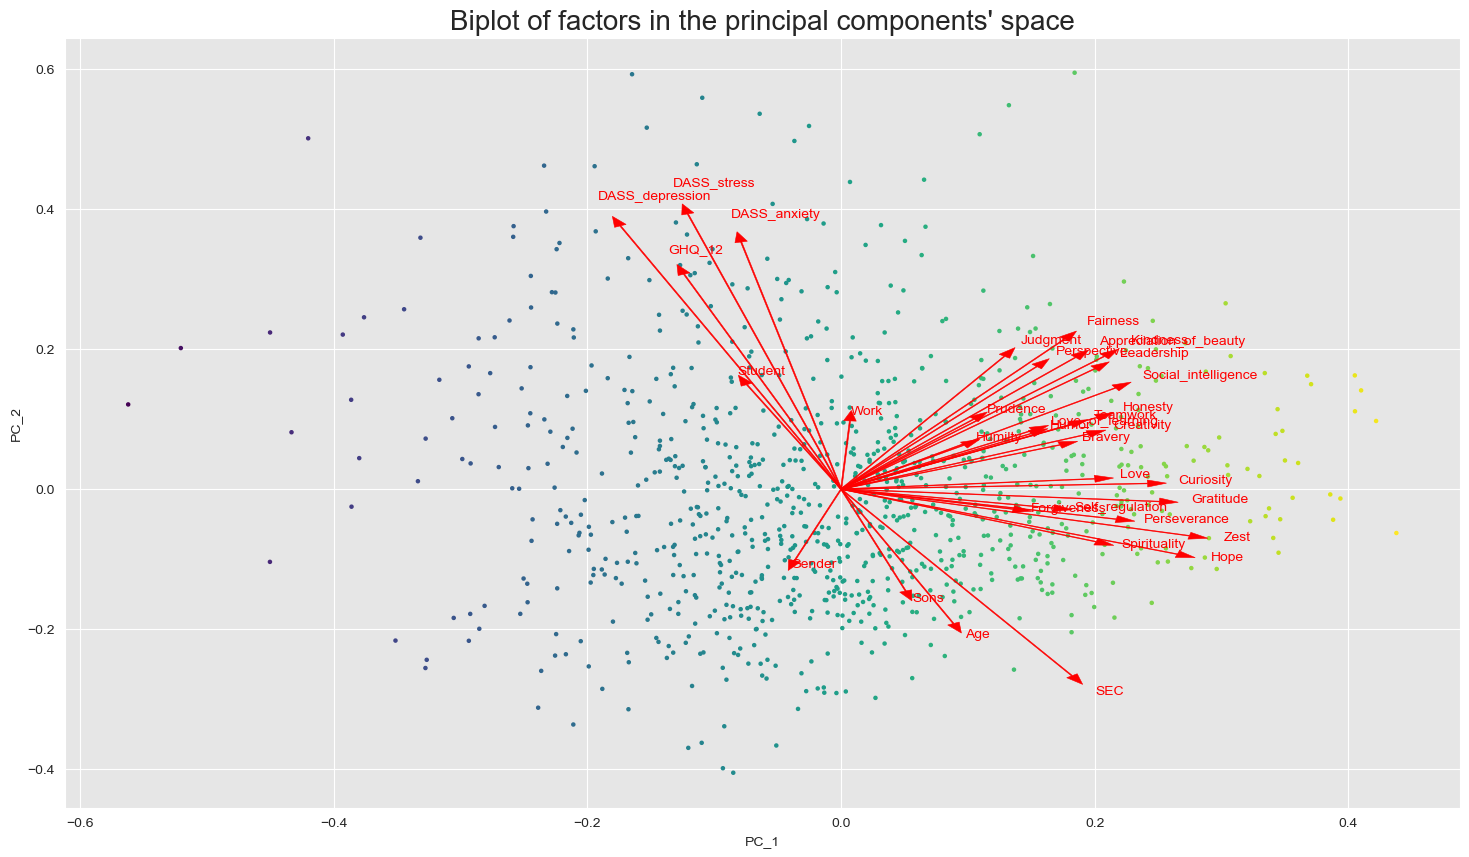

In [39]:
#%%BIPLOT
# PCs = X @ V, so X = PCs @ V_T. Considering only 2 PCs PC1 and PC2:
# PC1 @ V1 + PC2 @ V2 = X and for each factor Xj
# Xj = y1 * V1_j + y2 * V2_j
# So we can write the original factors as linear combinations of the principal components basis,
# having the principal_directions' coefficients as weights
plt.figure(figsize = [18, 10])

def biplot(PC, principal_directions, list_variable_names, idx_1 = 0, idx_2 = 1):
     
    # idx_1, idx_2 are indexes of the PCs to be plotted (es. PC1 and PC_3)
    
    PC_1 = PC[:, idx_1] # first principal component
    PC_2 = PC[:, idx_2] # second principal component
    
    PC_1 = PC_1/(max(PC_1) - min(PC_1))
    PC_2 = PC_2/(max(PC_2) - min(PC_2))
    
    
    plt.scatter(PC_1, PC_2, s = 5, c = PC_1, cmap = 'viridis')
    
    
    n = principal_directions.shape[0] # it's equal to the number of original factors
    
    for j in range(n):
        plt.arrow( x = 0, y = 0, # coordinates of the arrow base
                   dx = principal_directions[j, idx_1], # PC1 coordinate of arrow
                   dy = principal_directions[j, idx_2], # PC2 coordinate of arrow
                   color = 'red', head_width = 0.01, lw = 0.4)
        
        plt.text( principal_directions[j, idx_1]*1.1, principal_directions[j, idx_2]*1.1,
                  list_variable_names[j], color = 'red', fontsize = 10)
        
    plt.title("Biplot of factors in the principal components' space", fontsize = 20)   
    plt.xlabel('PC_' + str(idx_1 + 1))
    plt.ylabel('PC_' + str(idx_2 + 1))
    
    return(None)
    

biplot(PC = PCs, 
       # with the transposition the eigenvectors V are on columns
       principal_directions = np.real(PCA_from_scratch.principal_directions.T),
       list_variable_names = cols,
       idx_1 = 0 , idx_2 = 1)

plt.show()